In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, mean_squared_error, confusion_matrix
from tqdm import tqdm_notebook
import matplotlib.colors
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import OneHotEncoder

In [0]:
data, labels = make_blobs(n_samples = 1000, n_features = 2, centers = 4, random_state = 0)

In [0]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red", "yellow", "green"])

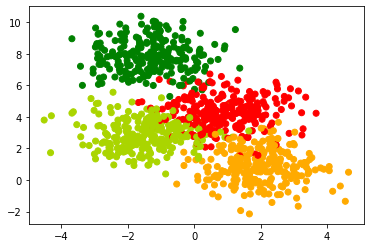

In [50]:
plt.scatter(data[:,0], data[:, 1], c = labels, cmap=my_cmap)
plt.show()

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify = labels, random_state = 0)

In [52]:
enc = OneHotEncoder()
Y_OH_train = enc.fit_transform(np.expand_dims(Y_train, 1)).toarray()
Y_OH_val = enc.fit_transform(np.expand_dims(Y_val, 1)).toarray()
print(Y_OH_train.shape, Y_OH_val.shape)

(750, 4) (250, 4)


In [0]:
class FNN_vectorized:
  def __init__(self, W1, W2):
    self.W1 = W1.copy()
    self.W2 = W2.copy()
    self.B1 = np.zeros((1, 2))
    self.B2 = np.zeros((1, 4))
  
  def sigmoid(self, X):
    return 1. / (1. + np.exp(-X))
  
  def grad_sigmoid(self, X):
    return X * (1 - X)
  
  def forward_pass(self, X):
    self.A1 = np.matmul(X, self.W1) + self.B1     # (N, 2) * (2, 2) -> (N, 2)
    self.H1 = self.sigmoid(self.A1)               # (N, 2)
    self.A2 = np.matmul(self.H1, self.W2) + self.B2       # (N, 2) * (2, 4) -> (N, 4)
    self.H2 = self.sigmoid(self.A2)                   # (N, 4)
    return self.H2
  
  def softmax(self, X):
    exp_sum = np.sum(np.exp(X))
    return np.exp(X) / exp_sum
  
  def grad(self, X, Y):
    self.forward_pass(X)
    
    self.dA2 = self.H2 - Y          # (N, 4)
    self.dW2 = np.matmul(self.H1.T, self.dA2)         # (2, N) * (N, 4) -> (2, 4)
    self.dB2 = np.sum(self.dA2, axis = 0).reshape(1, -1)                   # (1, 4)
    self.dH1 = np.matmul(self.dA2, self.W2.T)            # (N, 4) * (4, 2) -> (N, 2)
    self.dA1 = np.multiply(self.dH1, self.grad_sigmoid(self.H1))    # (N, 2) * (N, 2) -> (N, 2)
    self.dW1 = np.matmul(X.T, self.dA1)               # (2, N) * (N, 2) -> (2, 2)
    self.dB1 = np.sum(self.dA1, axis = 0).reshape(1, -1)                  # (1, 2)
  
  def fit(self, X, Y, epochs = 100, eta = 0.1):

    loss = {}
    for i in tqdm_notebook(range(epochs), total = epochs, unit = "epoch"):
      self.grad(X, Y)
        
      m = X.shape[0]
      self.W1 -= eta * self.dW1 / m
      self.W2 -= eta * self.dW2 / m
      self.B1 -= eta * self.dB1 / m
      self.B2 -= eta * self.dB2 / m

      Y_pred = self.predict(X)
      loss[i] = log_loss(np.argmax(Y, axis=1), Y_pred)
    plt.plot(list(loss.values()))
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()
  
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()

In [0]:
W1, W2 = np.random.random((2, 2)), np.random.random((2, 4))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


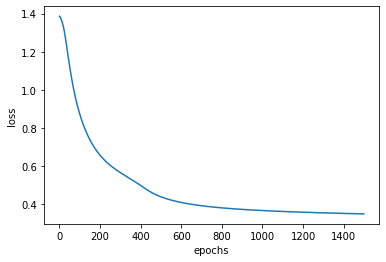

In [120]:
ffn = FNN_vectorized(W1, W2)
ffn.fit(X_train, Y_OH_train, epochs = 1500, eta = 0.5)

In [122]:
Y_pred_train = ffn.predict(X_train)
Y_pred_train = np.argmax(Y_pred_train, 1)
print(accuracy_score(Y_pred_train, Y_train))
Y_pred_val = ffn.predict(X_val)
Y_pred_val = np.argmax(Y_pred_val, 1)
print(accuracy_score(Y_pred_val, Y_val))

0.888
0.888


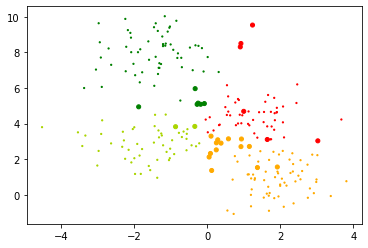

In [125]:
plt.scatter(X_val[:,0], X_val[:,1], c=Y_pred_val, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_val-Y_val))+.1))
plt.show()

In [131]:
cnf = confusion_matrix(Y_val, Y_pred_val)
print(cnf)

[[49  7  2  5]
 [ 1 62  0  0]
 [ 2  7 52  1]
 [ 3  0  0 59]]
